### Setup

#### Imports

In [9]:
import json
import folium
import random
import requests
import kml2geojson
import numpy as np
import pandas as pd
import urllib.parse
import seaborn as sns
import networkx as nx
import link_identifier
import pymysql.cursors
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from geopy import distance
from sklearn.neighbors import KernelDensity
from mpl_toolkits.basemap import Basemap as Basemap
from sklearn.datasets import fetch_species_distributions

inputPath = "/vagrant/google_maps_SEC/data/Input/"
resultPath = "/vagrant/google_maps_SEC/data/NetworkX_Results/"

# import constants
# from mpl_toolkits.basemap import Basemap
# also install `pip install basemap-data-hires`

#### Defines

In [10]:
# this information is hardcoded
dataCenters =  {
                "CMEAurora" : {
                        "idx": 0,
                        "name":"CMEAurora", 
                        "lat": 41.7965685, 
                        "lon": -88.245206,
                        "searchRadius": 0.01}, 
                "ThreeFityCermakChicago" : {
                        "idx": 1,
                        "name":"ThreeFityCermakChicago", 
                        "lat": 41.8533031, 
                        "lon": -87.6318695,
                        "searchRadius": 0.01},
                "ThreeFityCermakNJ" : {
                        "idx": 2,
                        "name":"ThreeFityCermakNJ", 
                        "lat": 40.5842564, 
                        "lon": -74.2443242,
                        "searchRadius": 0.01},
                "NY5Secaucus" : {
                        "idx": 3,
                        "name":"NY5Secaucus", 
                        "lat": 40.7785384, 
                        "lon": -74.0744313,
                        "searchRadius": 0.01},
                "NY2Secaucus" : {
                        "idx": 4,
                        "name":"NY2Secaucus", 
                        "lat": 40.7772145, 
                        "lon": -74.0781314,
                        "searchRadius": 0.01}, 
                # "NY4Secaucus" : {"name":"NY4Secaucus", "lat": 40.7772145, "lon": -74.0781314}, 
                "NJ2Weehawken" : {
                        "idx": 5,
                        "name":"NJ2Weehawken", 
                        "lat": 40.7618291, 
                        "lon": -74.0272254,
                        "searchRadius": 0.01},
                "NYSEMahwah" : {
                        "idx": 6,
                        "name":"NYSEMahwah", 
                        "lat": 41.0783617, 
                        "lon": -74.1551081,
                        "searchRadius": 0.01}, 
                "FedWashingtonDC" : {
                        "idx": 7,
                        "name":"FedWashingtonDC", 
                        "lat": 38.9028647, 
                        "lon": -77.0313835,
                        "searchRadius": 0.01}, 
                "TmxToronto" : {
                        "idx": 8,
                        "name":"TmxToronto", 
                        "lat": 43.6486441, 
                        "lon": -79.3840116,
                        "searchRadius": 0.1}
                }
                
dataCenterNames = list(dataCenters.keys())
numberOfDataCenters = len(dataCenterNames)

print("Number Of Data Centers: ", numberOfDataCenters)

# defining a general basemap for plotting graphs overlay and colormap for path depiction
m = Basemap(
        projection='merc',
        epsg='4269',
        llcrnrlon=-90,llcrnrlat=38,urcrnrlon=-70,urcrnrlat=45,
        # lat_1=32,lat_2=45,lon_0=-95,
        resolution="h",
        suppress_ticks=True)
cmap = ['r', 'b', "yellow", 'm', "orange", "purple", "pink", "brown", "gold", "violet", "limegreen", "darkorange", "grey"]

Number Of Data Centers:  9


#### SQL connection setup

In [11]:
# Establish Connection to SQL Server
connection = pymysql.connect(host='127.0.0.1',  # type: ignore
						port=3306,
						user='root',
						password='vagrant',
						db='python_fcc_db_test',
						charset='utf8mb4',
						cursorclass=pymysql.cursors.DictCursor,
						autocommit=True)

cursor = connection.cursor()

#### Helper Functions

In [12]:
# defining the node Object
class Node():
    def __init__(self, lat, lon, height, email,  callsign, r):
        if email==None:
            self.id = str(round(lat, 6)) + str(round(lon, 6))
        else:
            self.id = str(round(lat, 6)) + str(round(lon, 6)) + "-" + email
        # self.id = callsign + "-" + str(r)
        self.lat = round(lat, 6)
        self.lon = round(lon, 6)
        self.height = round(height, 6)
        self.email = email
        self.callSign = callsign

In [13]:
class nxHelper:
    def __init__(self):
        print("iniitiated..")

    # find points that are in radius of the center by distance
    def findPointsClosestTo(self, centerLat, centerLon, radius, G):
        diff = radius #difference in latitide/longitude allowed to deviate from the center point
        nodesNear10kmOfCenter = filter(lambda n: ((abs(G.nodes[n]['data'].lat - centerLat) <= diff) and (abs(G.nodes[n]['data'].lon - centerLon) <= diff)), list(G.nodes()))
        return list(nodesNear10kmOfCenter)

    # find nodes that have the highest degree - limit number of nodes returned by the second argument
    def findNodesWithHighestDegree(self, G, numberOfTopNodes):
        degreeList = sorted(G.degree, key=lambda x: x[1], reverse=True)
        return degreeList[0:numberOfTopNodes]

    def intersection(self, list1, list2):
        temp = set(list2)
        lst3 = [value for value in list1 if value in temp]
        return lst3

### Data

#### Reading Input Data

In [14]:
# Read data from DB using SQL query and filtered links sent by Matt
fd = open(inputPath+"sql_query_for_ipynb.sql", 'r')
sql = fd.read()        
cursor.execute(sql)
results = cursor.fetchall()

# Read callsigns to filter from Matt's Data
filter_df = pd.read_csv(inputPath+"finalstep5.csv")
filter_df_j = pd.read_csv(inputPath+"path_company.csv", sep = '|')

print("Number of records in the database:", len(results))
print("Number of filtered records exported:", len(filter_df))
print("Number of filtered records exported:", len(filter_df_j))

Number of records in the database: 601754
Number of filtered records exported: 16078
Number of filtered records exported: 22578


#### Processing Data

In [15]:
# Load the call signs in a set for filtering
callsign_set = set()
for i in range(len(filter_df['callsign'])):
    callsign_set.add(filter_df['callsign'][i])

# senderPoints = list of sender node objects, receiverPoints = list of receiver node objects
senderPoints = []
receiverPoints = []

# append filtered data to list of objects
for result in results:
    if result['call_sign'] in callsign_set:

        myNode = Node(result['lat_decimal'], result['lon_decimal'], result['r_ground_elevation'], result['email'], result['call_sign'], 1)
        senderPoints.append(myNode)

        myNode_r = Node(result['r_lat_decimal'], result['r_lon_decimal'], result['r_ground_elevation'], result['email'], result['call_sign'], 2)
        receiverPoints.append(myNode_r)

print("Number of nodes in data:", len(senderPoints))

Number of nodes in data: 21160


#### Graph Initialization

In [16]:
# Graph initialization
G = nx.Graph()
pos={}

# adding nodes to graph and setting their aboslute position using coordinates in map
for node in [*senderPoints, *receiverPoints]:
    node1 = node.id
    if node1 in G:
        continue
    mx1, my1 = m(node.lon, node.lat)
    pos[node1] = (mx1, my1)
    G.add_node(node1, pos=(node.lat, node.lon), data=node)

# add edges
for i in range(min(len(senderPoints), len(receiverPoints))):
    node1 = senderPoints[i].id
    node2 = receiverPoints[i].id

    # no self loops
    if(node1==node2 or (node1 not in G) or (node2 not in G) or (G.has_edge(node1, node2))):
        continue

    # compute length or distance between sender and receiver node
    dist = distance.distance((senderPoints[i].lat, senderPoints[i].lon), (receiverPoints[i].lat, receiverPoints[i].lon)).miles
    G.add_edge(node1, node2, weight=dist)


print("Number of nodes in the Graph:", G.number_of_nodes())
print("Number of edges in the Graph:", G.number_of_edges())

Number of nodes in the Graph: 15303
Number of edges in the Graph: 12787


### Plot paths

#### Whole graph using filtered data

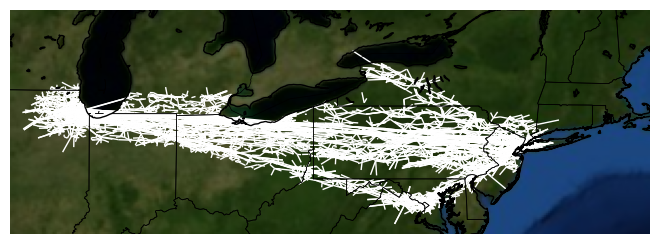

In [17]:
# source: https://stackoverflow.com/questions/19915266/drawing-a-graph-with-networkx-on-a-basemap
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

#### Points closest to exchanges

In [58]:
# 2D matrix to store minimum number of links between any 2 data centers
minNumberOfLinksBetweenDataCenters = [[10000]*numberOfDataCenters]*numberOfDataCenters

# 2D matrix to store shortest path length between any 2 data centers
shortestPathLengthBetweenDataCenters = [[10000]*numberOfDataCenters]*numberOfDataCenters

# list of lists to store closest nodes (in randomized order) to each data center (order same as dict)
h = nxHelper()
nodesClosestToDataCenters = []
for A in dataCenters:
    closestPoints = h.findPointsClosestTo(dataCenters[A]["lat"], dataCenters[A]["lon"], dataCenters[A]["searchRadius"], G)
    random.shuffle(closestPoints)
    nodesClosestToDataCenters.append(closestPoints)

# 2D matrix to store geographic distance between any 2 data centers
geographicDistanceBetweenDataCenters = []
for A in dataCenters:
    dist = []
    for B in dataCenters:
        dist.append(distance.distance((dataCenters[A]["lat"], dataCenters[A]["lon"]), (dataCenters[B]["lat"], dataCenters[B]["lon"])).miles)
    geographicDistanceBetweenDataCenters.append(dist)

# logs
print("\n{: >45} {: >20}".format(*["", "Geogrphic Distance (miles)"]))
for A, idxA in zip(dataCenterNames, range(numberOfDataCenters)):
    for B, idxB in zip(dataCenterNames[idxA+1:], range(idxA+1,numberOfDataCenters)):
        print("{: >45} {: >20}".format(*[A+" - "+B, round(geographicDistanceBetweenDataCenters[dataCenters[A]["idx"]][dataCenters[B]["idx"]], 4)]))

# logs
print("\n{: >45} {: >20}".format(*["\t", "#Points near datacenter"]))
for A in dataCenters:
    print("{: >45} {: >20}".format(*[A, len(nodesClosestToDataCenters[dataCenters[A]["idx"]])]))

iniitiated..

                                              Geogrphic Distance (miles)
           CMEAurora - ThreeFityCermakChicago              31.9027
                CMEAurora - ThreeFityCermakNJ             733.7937
                      CMEAurora - NY5Secaucus              740.096
                      CMEAurora - NY2Secaucus              739.921
                     CMEAurora - NJ2Weehawken             742.7368
                       CMEAurora - NYSEMahwah             732.5794
                  CMEAurora - FedWashingtonDC             624.1718
                       CMEAurora - TmxToronto             468.4896
   ThreeFityCermakChicago - ThreeFityCermakNJ             702.3138
         ThreeFityCermakChicago - NY5Secaucus             708.5158
         ThreeFityCermakChicago - NY2Secaucus             708.3415
        ThreeFityCermakChicago - NJ2Weehawken             711.1609
          ThreeFityCermakChicago - NYSEMahwah             700.8866
     ThreeFityCermakChicago - FedWashingto

In [19]:
# display all possible source and destination points
for A in dataCenters:
    nx.draw_networkx_nodes(G, pos, nodelist=nodesClosestToDataCenters[dataCenters[A]["idx"]], node_size=1, node_color='white')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

### Actual Code

#### shortest paths from point in 10km radius of CME to 10km of NASDAQ

In [30]:
# find the paths from all sets to all other sets
# print("Found Path #", end='')

pathsEdgeList = [] # edges in the path
pathsNodeList = [] # nodes in the path
pathsNodeList_dict = {} # nodes in the path
pathsEdges_set = set()
pathsNumberOfLinks = [] # number of links in each path
pathsLength = [] # length of each path in miles

numberOfPaths = 0 # keep count of total number of paths found
numberOfPathsLimit = 200

# iterate over all sets of points near data centers
for A, idxA in zip(dataCenterNames, range(numberOfDataCenters)):
        for B, idxB in zip(dataCenterNames[idxA:], range(idxA,numberOfDataCenters)):

                if A==B:
                        continue

                print("Searching paths between", A, " and", B)
                id = A + "-" + B
                pathsNodeList_dict[id] = []

                email_set = set()

                # check for all paths from nodes in set A to nodes in set B 
                for nA in nodesClosestToDataCenters[idxA]:
                        for nB in nodesClosestToDataCenters[idxB]:

                                # id of node is stored in 0th index of the list element's tuple
                                numberOfPaths = 0

                                if( nx.has_path(G, nA, nB) ):

                                        shortestPath = nx.shortest_path(G, source = nA, target = nB, weight='weight')
                                        shortestPathWeight = nx.path_weight(G, shortestPath, weight="weight")
                                        shortestPathLength = len(shortestPath)
                                        
                                        minNumberOfLinksBetweenDataCenters[idxA][idxB] = min(minNumberOfLinksBetweenDataCenters[idxA][idxB], shortestPathLength)
                                        shortestPathLengthBetweenDataCenters[idxA][idxB] = min(shortestPathLengthBetweenDataCenters[idxA][idxB], shortestPathWeight)

                                        

                                        print("Shortest Path Weight: ", shortestPathWeight)
                                        print("Number of links in the shortest path: ", shortestPathLength)

                                        for path in nx.shortest_simple_paths(G, source = nA, target = nB, weight="weight"):

                                                pathWeight = nx.path_weight(G, path, weight='weight')

                                                # if path length is not within 50 miles of the distance between datacenter A and B
                                                if abs(pathWeight - shortestPathLengthBetweenDataCenters[idxA][idxB]) > 20:
                                                        break

                                                prevLen = len(email_set)
                                                # do not include paths that have multiple emails in the nodes of paths
                                                currentEmailSet = set()
                                                for node in path:
                                                        currentEmailSet.add(G.nodes[node]['data'].email)
                                                if(len(currentEmailSet)>1):
                                                        continue
                                                        
                                                for node in path: 
                                                        email_set.add(G.nodes[node]['data'].email)

                                                if(len(email_set) == prevLen):
                                                        continue

                                                pathEdges = list(zip(path,path[1:]))
                                                pathsEdgeList.append(pathEdges)
                                                pathsNodeList.append(path)
                                                pathsNodeList_dict[id].append(path)
                                                pathsLength.append(pathWeight)
                                                for i in pathEdges:
                                                        pathsEdges_set.add(i)

                                                numberOfPaths = numberOfPaths + 1
                                                if(numberOfPaths > numberOfPathsLimit):
                                                        numberOfPaths = 0
                                                        break
                                                b = "Found Path #" + str(numberOfPaths)
                                                print (b)

Searching paths between CMEAurora  and ThreeFityCermakChicago
Shortest Path Weight:  129.9507988572997
Number of links in the shortest path:  6
Found Path #1
Shortest Path Weight:  99.97748786419285
Number of links in the shortest path:  4
Found Path #1
Shortest Path Weight:  99.98864943245971
Number of links in the shortest path:  4
Shortest Path Weight:  100.29229870831406
Number of links in the shortest path:  5
Shortest Path Weight:  100.30346027658095
Number of links in the shortest path:  5
Shortest Path Weight:  32.20459365913583
Number of links in the shortest path:  2
Shortest Path Weight:  32.2157552274027
Number of links in the shortest path:  2
Shortest Path Weight:  100.6503608708818
Number of links in the shortest path:  6
Shortest Path Weight:  100.66152243914865
Number of links in the shortest path:  6
Shortest Path Weight:  130.219028959636
Number of links in the shortest path:  6
Searching paths between CMEAurora  and ThreeFityCermakNJ
Shortest Path Weight:  778.70654

#### Summary

In [43]:
print("Number of Paths Found: ", len(pathsLength))
print("{: >50} {: >20} {: >20}".format(*["\t", "Shortest Path Length", "Min number of Links"]))
for A, idxA in zip(dataCenterNames, range(numberOfDataCenters)):
        for B, idxB in zip(dataCenterNames[idxA:], range(idxA, numberOfDataCenters)):
                print("{: >50} {: >20} {: >20}".format(*[A+" - "+B, round(shortestPathLengthBetweenDataCenters[idxA][idxB], 4), minNumberOfLinksBetweenDataCenters[idxA][idxB]]))

Number of Paths Found:  77
                                                 	 Shortest Path Length  Min number of Links
                             CMEAurora - CMEAurora                10000                10000
                CMEAurora - ThreeFityCermakChicago              32.2046                    2
                     CMEAurora - ThreeFityCermakNJ              706.223                   23
                           CMEAurora - NY5Secaucus              16.8721                    3
                           CMEAurora - NY2Secaucus                    0                    1
                          CMEAurora - NJ2Weehawken               2.4056                    2
                            CMEAurora - NYSEMahwah              23.7414                    4
                       CMEAurora - FedWashingtonDC             188.9896                    8
                            CMEAurora - TmxToronto                10000                10000
   ThreeFityCermakChicago - ThreeFityCermak

In [59]:

# draw graph showing all paths
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
for i in range(len(pathsLength)):
    nx.draw_networkx_edges(G, pos, edgelist=pathsEdgeList[i],edge_color=cmap[i%10], width=0.5, connectionstyle='arc3, rad = 0.3')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.savefig('fooAll_test4.pdf')
plt.show()


#### show paths using edges

In [ ]:
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
for j in pathsEdges_set:
        nx.draw_networkx_edges(G, pos, edgelist=[j] ,edge_color='r', width=0.5, connectionstyle='arc3, rad = 0.3')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.savefig('fooAll1.pdf')
plt.show()

### Output emails and nodes

In [60]:
# list all associated email in the path nodes
emailSet = set()
callsignSet = set()

for path in pathsNodeList:
    for node in path:

        n = G.nodes[node]['data']

        emailSet.add(n.email)
        callsignSet.add(n.callSign)

In [61]:
print(len(callsignSet))
k = 0
for i in pathsNodeList:
    k = k + len(i)

print(k)

384
1067


### Exports

#### Email and Callsigns

In [63]:
pathCallSignFile = open(resultPath+"pathCallSign.txt", "w")
for path, idx in zip(pathsNodeList, range(len(pathsNodeList))):
    for node in path:
        pathCallSignFile.write(str(idx) + " " +
                                str(G.nodes[node]['data'].callSign) + " " + 
                                str(G.nodes[node]['data'].lat) + " " +
                                str(G.nodes[node]['data'].lon) + " " +
                                str(G.nodes[node]['data'].email) + "\n")

In [19]:
dataFile = open(resultPath+"data.txt", "w")
for i in pathsEdgeList:
    for j in range(len(i)):
        dataFile.write(str(G.nodes[i[j][0]]['data'].callSign) + " " +  
                            str(G.nodes[i[j][0]]['data'].lat) + " " + 
                            str(G.nodes[i[j][0]]['data'].lon) + " " + 
                            str(G.nodes[i[j][1]]['data'].lat) + " " + 
                            str(G.nodes[i[j][1]]['data'].lon) + " " + 
                            str(G.nodes[i[j][0]]['data'].email) + "\n")

In [ ]:
emailFile = open(resultPath+"emailFile.txt", "w")
callsignFile = open(resultPath+"callsignFile.txt", "w")

for email in emailSet:
    emailFile.write(str(email) + "\n")
for callsign in callsignSet:
    callsignFile.write(callsign + "\n")

emailFile.close()
callsignFile.close()

### DUMP

In [ ]:
# CME_datacenter_lat = 41.7993472
# CME_datacenter_long = -88.2417858

# NASDAQ_datacenter_lat = 40.585606187252445
# NASDAQ_datacenter_long = -74.24154709139276

# FedReserve_hq_lat = 38.893279884940014
# FedReserve_hq_long = -77.04555349377686

# #  sort nodes by their degree
# a = sorted(G.degree, key=lambda x: x[1], reverse=True)
# a[0:10]

DFS Tree of a sample node

[('41.898389-88.220667-rca_projects@imc.com', '41.800556-88.236111-rca_projects@imc.com'), ('41.800556-88.236111-rca_projects@imc.com', '41.860583-88.427083-rca_projects@imc.com'), ('41.860583-88.427083-rca_projects@imc.com', '41.796222-88.242167-rca_projects@imc.com'), ('41.860583-88.427083-rca_projects@imc.com', '41.858639-88.486444-rca_projects@imc.com'), ('41.860583-88.427083-rca_projects@imc.com', '41.858444-88.486222-rca_projects@imc.com')]


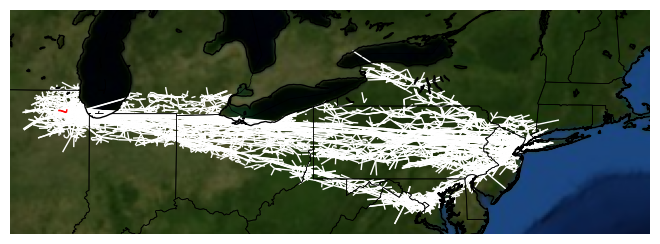

In [25]:
# # Find the node object of this coordinate
# sourceNode = str(round(41.89838888855556, 6)) + str(round(-88.220666666, 6)) + str("-rca_projects@imc.com")
# path = nx.dfs_tree(G, source=sourceNode, depth_limit=300)
# print(path.edges())

# nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
# nx.draw_networkx_edges(G, pos, edgelist=path.edges(),edge_color='r', connectionstyle='arc3, rad = 0.3')
# m.drawcoastlines()
# m.drawcountries()
# m.drawstates()
# m.bluemarble()
# plt.show()

Shortest path from a node near Chicago to New York

In [ ]:
# # highlighting the shortest path from a node to destination
# flag = False
# node1 = ""
# node2 = ""
# pathsEdgeList = [] # edges in the path
# pathsNodeList = [] # nodes in the path
# numberOfPaths = 0
# numberOfPathsLimit = 30

# # get list of nodes and shuffle them
# nodeList = list(G.nodes(data=True))
# random.shuffle(nodeList)
# numberOfNodes = len(nodeList)

# for i in range(numberOfNodes):
        
#         for j in range(numberOfNodes):

#                 if(j==i):
#                         continue

#                 # id of node is stored in 0th index of the list element's tuple
#                 node1 = nodeList[i][1]['data']
#                 node2 = nodeList[j][1]['data']

#                 nodeList[0][1]['data'].email

#                 if( (node1.lon<-85 and node1.lat>41) and (node2.lon>-75) and  (nx.has_path(G, node1.id, node2.id)) ):

#                         path = nx.shortest_path(G, source = node1.id, target = node2.id)
                        
#                         pathEdges = list(zip(path,path[1:]))
#                         pathsEdgeList.append(pathEdges)
#                         pathsNodeList.append(path)
                        
#                         numberOfPaths = numberOfPaths + 1
#                         print("Found Path #", numberOfPaths)
#                         if numberOfPaths >= numberOfPathsLimit:
#                                 flag = True
#                                 break

#                         # go to a different root node if a path is found
#                         break

#         if flag==True:
#                 break

In [ ]:
# # list all associated email in the path nodes
# # find minimum distance node to CME and NASDAQ for each apth

# emailSet2 = set()

# minDistToCME2 = []
# minDistToNASDAQ2 = []

# minDistNodeToCME2 = []
# minDistNodeToNASDAQ2 = []

# for path in pathsNodeList:

#     pathMinDistToCME2 = 10000.0
#     pathMinDistToNASDAQ2 = 10000.0

#     pathMinDistNodeToCME2 = ""
#     pathMinDistNodeToNASDAQ2 = ""

#     for node in path:

#         n = G.nodes[node]['data']

#         emailSet2.add(n.email)

#         distToCME2 = distance.distance((n.lat, n.lon), (CME_datacenter_lat, CME_datacenter_long)).miles
#         distToNASDAQ2 = distance.distance((n.lat, n.lon), (NASDAQ_datacenter_lat, NASDAQ_datacenter_long)).miles

#         pathMinDistToCME2 = min(pathMinDistToCME2, distToCME2)
#         pathMinDistToNASDAQ2 = min(pathMinDistToNASDAQ2, distToNASDAQ2)

#         if(pathMinDistToCME2==distToCME2):
#             pathMinDistNodeToCME2 = n.id
#         if(pathMinDistToNASDAQ2==distToNASDAQ2):
#             pathMinDistNodeToNASDAQ = n.id
    
#     minDistToCME2.append(pathMinDistToCME2)
#     minDistToNASDAQ2.append(pathMinDistToNASDAQ2)
#     minDistNodeToCME2.append(pathMinDistNodeToCME2)
#     minDistNodeToNASDAQ2.append(pathMinDistNodeToNASDAQ2)

# print(minDistToCME2)
# print(minDistNodeToCME2)
# for i in minDistNodeToCME2:
#     print(G.nodes[i]['data'].id)
# for email in emailSet2:
#     print(email)

In [ ]:
# redundantIndex = []

# c = 0
# for id in pathsNodeList_dict.keys():

#     for idx1 in range(len(pathsNodeList_dict[id])):

#         for idx2 in range(idx1, len(pathsNodeList_dict[id])):

#             l1 = pathsNodeList[idx1]
#             l2 = pathsNodeList[idx2]

#             email_set = set()
#             for node in [*pathsNodeList[idx1], *pathsNodeList[idx2]]:
#                 email_set.add(G.nodes[node]['data'].email)

#             if(len(email_set)==1):
#                 redundantIndex.append(c+idx2)
            
#     c = c + len(pathsNodeList_dict[id])

# filteredpathNodesList = [pathsNodeList[idx] for idx in range(len(pathsNodeList)) if idx not in redundantIndex]

# print("Length of initial path list:", len(pathsNodeList))
# print("Length of filtered path list:", len(filteredpathNodesList))